In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision
from ase.io import read
from pathlib import Path

from xcquinox import net_Sara
from xcquinox import xc
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer, Optimizer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

/home/saru/anaconda3/envs/test_xcq/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Pre-training SCAN Networks

Since we now need access to higher derivative values (like $\nabla^2 \rho$ and $\tau$), I will opt for physical values generated by a PySCF calculation to generate the necessary inputs.

Below, I create the SCAN and HEG functions from `pylibxc` to generate the enhancement factors later.

In [2]:
func_scan_x = pylibxc.LibXCFunctional("mgga_x_scan", "unpolarized")
func_scan_c = pylibxc.LibXCFunctional("mgga_c_scan", "unpolarized")

func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")

Below, I load in the G2/97 dataset saved in the `xcquinox/scrips/script_data` folder. I will select from this set the molecules `LiH` and `LiF` to generate relevant training points.

In [3]:
def get_inputs_from_datasets(path, selected_mol_inds=None, only_print=False):
    """Get inputs from a given dataset

    It retuns the outputs "rho" from pyscf for the selected molecules. Remember that
    rho corresponds to (they are calculated for m-GGA):
        rho = rho0, dx, dy, dz, laplacian, tau,
    where rho0 is the density, dx, dy, dz are the first derivatives of the density,
    laplacian is the second derivative of the density, and tau is the kinetic energy density.
    If you wish to print the dataset, set only_print=True.
    Args:
        path (str): Path to the dataset
        selected_mol_inds (list): List of indices of the selected molecules
        only_print (bool): If True, only print the dataset without extracting inputs
    Returns:
        total_rho (np.ndarray): The "rho" output from pyscf for the selected molecules.
    """
    dataset = read(path, ':')
    if only_print:
        for idx, at in enumerate(dataset):
            print(idx, at, at.info)
        return
    if selected_mol_inds is None:
        print('WARNING: No selected_mol_inds provided, using all molecules in the dataset')
        selected_mol_inds = list(range(len(dataset)))
        print('Selected molecules:', selected_mol_inds)
    
    selected_mols = [dataset[i] for i in selected_mol_inds]

    for idx, at in enumerate(selected_mols):
        print('Selected molecule', idx, at, at.info)
    for idx, at in enumerate(selected_mols):
        print(idx, 'Extraction GS inputs from', at)
        syms = at.get_chemical_symbols()
        pos = at.positions
        atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
        mol = gto.M(atom=atstr, basis='def2-tzvpd')
        mf = dft.RKS(mol)
        mf.xc = 'scan,scan'
        mf.grids.level = 5
        mf.kernel()
        ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
        dm = mf.make_rdm1()
        rho = dft.numint.eval_rho(mol, ao, dm, with_lapl=True, xctype='MGGA')
        if idx == 0:
            total_rho = rho
        else:
            total_rho = np.hstack([total_rho, rho])
    return total_rho



In [4]:
def from_rho_to_dict(all_rhos):
    """Transform the rho to a dictionary for libxc

    Remember that rho corresponds to (depending the case)
    LDA:
        rho = rho0
    GGA:
        rho = rho0, dx, dy, dz
    m-GGA:
        rho = rho0, dx, dy, dz, laplacian, tau,
    where rho0 is the density, dx, dy, dz are the first derivatives of the density,
    laplacian is the second derivative of the density, and tau is the kinetic energy density.
    Args:
        all_rhos (np.ndarray): All the rho values from the dataset.
    """
    N = all_rhos.shape[0]
    all_rho0 = all_rhos[0, :]
    if N > 1:
        all_sigma = all_rhos[1, :]**2 + all_rhos[2, :]**2 + all_rhos[3, :]**2
    if N > 4:
        all_lapl = all_rhos[4, :]
        all_tau = all_rhos[5, :]
    if N == 1:
        print('Only rho0 provided, using LDA')
        inp = np.vstack([all_rho0])
        ni = 1
    elif N == 4:
        print('Only rho0, dx, dy, dz provided, using GGA')
        inp = np.vstack([all_rho0, all_sigma])
        ni = 2
    elif N == 5:
        print('Only rho0, dx, dy, dz, laplacian provided, using m-GGA')
        inp = np.vstack([all_rho0, all_sigma, all_lapl])
        ni = 3
    elif N == 6:
        print('Only rho0, dx, dy, dz, laplacian, tau provided, using m-GGA')
        inp = np.vstack([all_rho0, all_sigma, all_lapl, all_tau])
        ni = 4
    else:
        raise ValueError('Invalid number of inputs: {}'.format(N))
    pylibxc_inp =  {}
    for i in range(ni):
        if i == 0:
            pylibxc_inp['rho'] = all_rho0
        elif i == 1:
            pylibxc_inp['sigma'] = all_sigma
        elif i == 2:
            pylibxc_inp['lapl'] = all_lapl
        elif i == 3:
            pylibxc_inp['tau'] = all_tau
    return inp, pylibxc_inp

In [5]:
target_path = Path.cwd().parent / 'scripts' / 'script_data' / 'haunschild_g2'/ 'g2_97.traj'
get_inputs_from_datasets(target_path, only_print=True)

0 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) {'CO': True, 'name': 'Carbon monoxide'}
1 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) {'CS': True, 'name': 'Carbon monosulfide'}
2 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen'}
3 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) {'HF': True, 'name': 'Hydrogen fluoride'}
4 Atoms(symbols='P2', pbc=False, calculator=SinglePointCalculator(...)) {'P2': True, 'name': 'Diphosphorus'}
5 Atoms(symbols='S2', pbc=False, calculator=SinglePointCalculator(...)) {'S2': True, 'name': 'Disulfur'}
6 Atoms(symbols='SH', pbc=False, calculator=SinglePointCalculator(...)) {'HS': True, 'name': 'Mercapto radical'}
7 Atoms(symbols='OS', pbc=False, calculator=SinglePointCalculator(...)) {'OS': True, 'name': 'Sulfur monoxide'}
8 Atoms(symbols='C2H', pbc=False, calculator=SinglePointCalculator(...)) {'C2H': True, 'name': 'Ethynyl radical'}

In [6]:
#The dataset contains 97 molecules. We will select a few of them to generate the relevant grids and descriptors.
#we'll use LiF and LiH as our molecules to generate the relevant grids and descriptors

selected_mol_inds = [25, 26]
total_rho = get_inputs_from_datasets(target_path, selected_mol_inds=selected_mol_inds)

Selected molecule 0 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride'}
Selected molecule 1 Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...)) {'LiH': True, 'name': 'Lithium hydride'}
0 Extraction GS inputs from Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...))
converged SCF energy = -107.434995479272
1 Extraction GS inputs from Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...))
converged SCF energy = -8.06737171564216


In [7]:
total_rho.shape

(6, 138304)

Below, I generate the necessary grid data that we will need. At the MGGA level, `dft.numint.eval_rho` returns an array of $\rho,\nabla_x\rho,\nabla_y\rho,\nabla_z\rho,\nabla^2\rho,\tau$.
S: I have created a function to automatically obtain the inputs rho for th emolecules, so we just need now to tranform that to the dictorioanry

In [8]:
inp, pylibxc_inp = from_rho_to_dict(total_rho)
print('Input shape:', inp.shape)

Only rho0, dx, dy, dz, laplacian, tau provided, using m-GGA
Input shape: (4, 138304)


In [9]:
np.savetxt('input.txt', inp)
np.save('pylibxc_input.npy', pylibxc_inp)
print('Pylibxc input:', pylibxc_inp)

Pylibxc input: {'rho': array([1.57903059e-08, 1.75072665e-08, 1.45068634e-08, ...,
       2.01532142e-01, 2.01532142e-01, 2.01532142e-01]), 'sigma': array([3.82529434e-18, 7.12919766e-18, 4.24135516e-18, ...,
       9.68808599e-01, 9.68808599e-01, 9.68808599e-01]), 'lapl': array([-1.26324525e-08, -1.56712911e-08, -1.11284629e-08, ...,
        2.81691522e+00,  2.81691522e+00,  2.81691522e+00]), 'tau': array([1.61625885e-10, 2.10351264e-10, 1.79810230e-10, ...,
       6.79422156e-01, 6.79422156e-01, 6.79422156e-01])}


In [10]:
inp = np.loadtxt('input.txt')
pylibxc_inp = np.load('pylibxc_input.npy', allow_pickle=True).item()
print('pylibxc_inp:', pylibxc_inp)

pylibxc_inp: {'rho': array([1.57903059e-08, 1.75072665e-08, 1.45068634e-08, ...,
       2.01532142e-01, 2.01532142e-01, 2.01532142e-01]), 'sigma': array([3.82529434e-18, 7.12919766e-18, 4.24135516e-18, ...,
       9.68808599e-01, 9.68808599e-01, 9.68808599e-01]), 'lapl': array([-1.26324525e-08, -1.56712911e-08, -1.11284629e-08, ...,
        2.81691522e+00,  2.81691522e+00,  2.81691522e+00]), 'tau': array([1.61625885e-10, 2.10351264e-10, 1.79810230e-10, ...,
       6.79422156e-01, 6.79422156e-01, 6.79422156e-01])}


Now we use the functions instantiated above to calculate the SCAN and HEG $e_x$ and $e_c$ values, which we divide to get the resulting SCAN enhancement factor values on the grid.

In [11]:
ref_scan_x = func_scan_x.compute(pylibxc_inp)
ref_scan_c = func_scan_c.compute(pylibxc_inp)

ref_lda_x = func_lda_x.compute(pylibxc_inp)
ref_lda_c = func_lda_c.compute(pylibxc_inp)

ref_scan_Fx = (ref_scan_x['zk']/ref_lda_x['zk'])[0]
ref_scan_Fc = (ref_scan_c['zk']/ref_lda_c['zk'])[0]

Below I set up a 85/15 train/test split with the points generated above.

In [12]:
#set up training/test indices
num_pts = inp.shape[1]
inds = np.arange(num_pts)

Ntrain = int(0.85*num_pts)
Ntest = num_pts - Ntrain
np.random.seed(12345)
train_inds = np.random.choice(inds, size=Ntrain, replace=False)
test_inds = [i for i in inds if i not in train_inds]

train_pts = inp[:, train_inds]
test_pts = inp[:, test_inds]
train_ref_Fx = ref_scan_Fx[train_inds]
train_ref_Fc = ref_scan_Fc[train_inds]

test_ref_Fx = ref_scan_Fx[test_inds]
test_ref_Fc = ref_scan_Fc[test_inds]

In [13]:
def plot_inputs(train_inps, test_inps):
    """Plot the inputs for the training and test sets

    Args:
        train_inps (np.ndarray): The inputs for the training set.
        test_inps (np.ndarray): The inputs for the test set.
    """
    inputs = ['rho', 'sigma', 'lapl', 'tau']
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()
    # We plot all the possible combinations : rho vs sigma, rho vs lapl, rho vs tau, sigma vs lapl, sigma vs tau, lapl vs tau
    i = 0
    for j in range(len(inputs)):
        for k in range(j+1, len(inputs)):
            axs[i].scatter(train_inps[j], train_inps[k], color='blue', label='Train', s=0.5)
            axs[i].scatter(test_inps[j], test_inps[k], color='red', label='Test', s=0.5)
            axs[i].set_xlabel(inputs[j])
            axs[i].set_ylabel(inputs[k])
            axs[i].legend()
            axs[i].set_xscale('log')
            axs[i].set_yscale('log')
            i += 1
    plt.tight_layout()

        


In [23]:
train_pts = np.loadtxt('train_pts.txt').T
test_pts = np.loadtxt('test_pts.txt').T

In [15]:
# plot_inputs(train_pts, test_pts)

The references and inputs are generated, now we train.

In [16]:
#sigma-based networks
s_scan_fx = net_Sara.MGGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc = net_Sara.MGGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fx_tr = net_Sara.MGGA_FxNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc_tr = net_Sara.MGGA_FcNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

I will train each network over 5000 steps with a linear schedule to decrease the LR over time.

In [17]:
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-6
OPTSTEPS = 5000
OPTDECAYBEGIN = 1000
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)

#create optimizers
optimizer = optax.chain(
    optax.adam(learning_rate=scheduler)
)
#train points shape mismatch -- typical shape vmap expects is (Npts, Ninputs), but eval_rho gives us the opposite shape.
pt_scan_fx = Pretrainer(model = s_scan_fx, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fc = Pretrainer(model = s_scan_fc, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

pt_scan_fxt = Pretrainer(model = s_scan_fx_tr, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fct = Pretrainer(model = s_scan_fc_tr, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

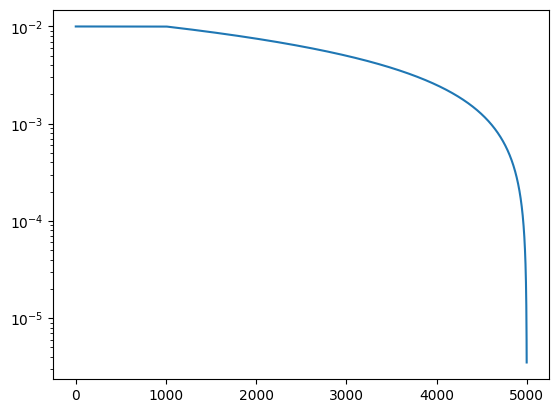

In [18]:
plt.plot(scheduler(np.arange(0, OPTSTEPS)))
plt.yscale('log')

In [19]:
# nmx, nlx = pt_scan_fx()
# nmc, nlc = pt_scan_fc()

# nmxt, nlxt = pt_scan_fxt()
# nmct, nlct = pt_scan_fct()

In [20]:
# net.save_xcquinox_model(nmx, path='pretrained_networks', loss=nlx)
# net.save_xcquinox_model(nmc, path='pretrained_networks', loss=nlc)
# net.save_xcquinox_model(nmxt, path='pretrained_networks', loss=nlxt)
# net.save_xcquinox_model(nmct, path='pretrained_networks', loss=nlct)

In [21]:
#load the models
nmx = net_Sara.load_xcquinox_model('pretrained_networks/MGGA_FxNet_sigma_d3_n16_s92017')
nlx = np.loadtxt('pretrained_networks/MGGA_FxNet_sigma_d3_n16_s92017_loss.txt')
nmc = net_Sara.load_xcquinox_model('pretrained_networks/MGGA_FcNet_sigma_d3_n16_s92017')
nlc = np.loadtxt('pretrained_networks/MGGA_FcNet_sigma_d3_n16_s92017_loss.txt')
nmxt = net_Sara.load_xcquinox_model('pretrained_networks/MGGA_FxNet_sigma_transform_d3_n16_s92017')
nlxt = np.loadtxt('pretrained_networks/MGGA_FxNet_sigma_transform_d3_n16_s92017_loss.txt')
nmct = net_Sara.load_xcquinox_model('pretrained_networks/MGGA_FcNet_sigma_transform_d3_n16_s92017')
nlct = np.loadtxt('pretrained_networks/MGGA_FcNet_sigma_transform_d3_n16_s92017_loss.txt')

{'depth': 3, 'nodes': 16, 'seed': 92017, 'name': 'MGGA_FxNet_sigma'}
Loading MGGA_FxNet_sigma model
depth: 3, nodes: 16, seed: 92017
<class 'xcquinox.net_Sara.MGGA_FxNet_sigma'>
Loaded pretrained_networks/MGGA_FxNet_sigma_d3_n16_s92017.eqx
{'depth': 3, 'nodes': 16, 'seed': 92017, 'name': 'MGGA_FcNet_sigma'}
Loading MGGA_FcNet_sigma model
depth: 3, nodes: 16, seed: 92017
<class 'xcquinox.net_Sara.MGGA_FcNet_sigma'>
Loaded pretrained_networks/MGGA_FcNet_sigma_d3_n16_s92017.eqx
{'depth': 3, 'nodes': 16, 'seed': 92017, 'name': 'MGGA_FxNet_sigma_transform'}
Loading MGGA_FxNet_sigma_transform model
depth: 3, nodes: 16, seed: 92017
<class 'xcquinox.net_Sara.MGGA_FxNet_sigma_transform'>
Loaded pretrained_networks/MGGA_FxNet_sigma_transform_d3_n16_s92017.eqx
{'depth': 3, 'nodes': 16, 'seed': 92017, 'name': 'MGGA_FcNet_sigma_transform'}
Loading MGGA_FcNet_sigma_transform model
depth: 3, nodes: 16, seed: 92017
<class 'xcquinox.net_Sara.MGGA_FcNet_sigma_transform'>
Loaded pretrained_networks/MGGA_

In [24]:
test_pred_fx = jax.vmap(nmx)(test_pts.T)
test_pred_fc = jax.vmap(nmc)(test_pts.T)

fx_mae = np.mean(abs(test_pred_fx - test_ref_Fx))
fc_mae = np.mean(abs(test_pred_fc - test_ref_Fc))
print(fx_mae, fc_mae)

test_pred_fxt = jax.vmap(nmxt)(test_pts.T)
test_pred_fct = jax.vmap(nmct)(test_pts.T)
 
fxt_mae = np.mean(abs(test_pred_fxt - test_ref_Fx))
fct_mae = np.mean(abs(test_pred_fct - test_ref_Fc))
print(fxt_mae, fct_mae)


0.005298897668978858 0.008580527414348359
0.0010545572555491708 0.003340370591985798


Text(0.5, 0.98, 'Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\rho,s,\\alpha$]')

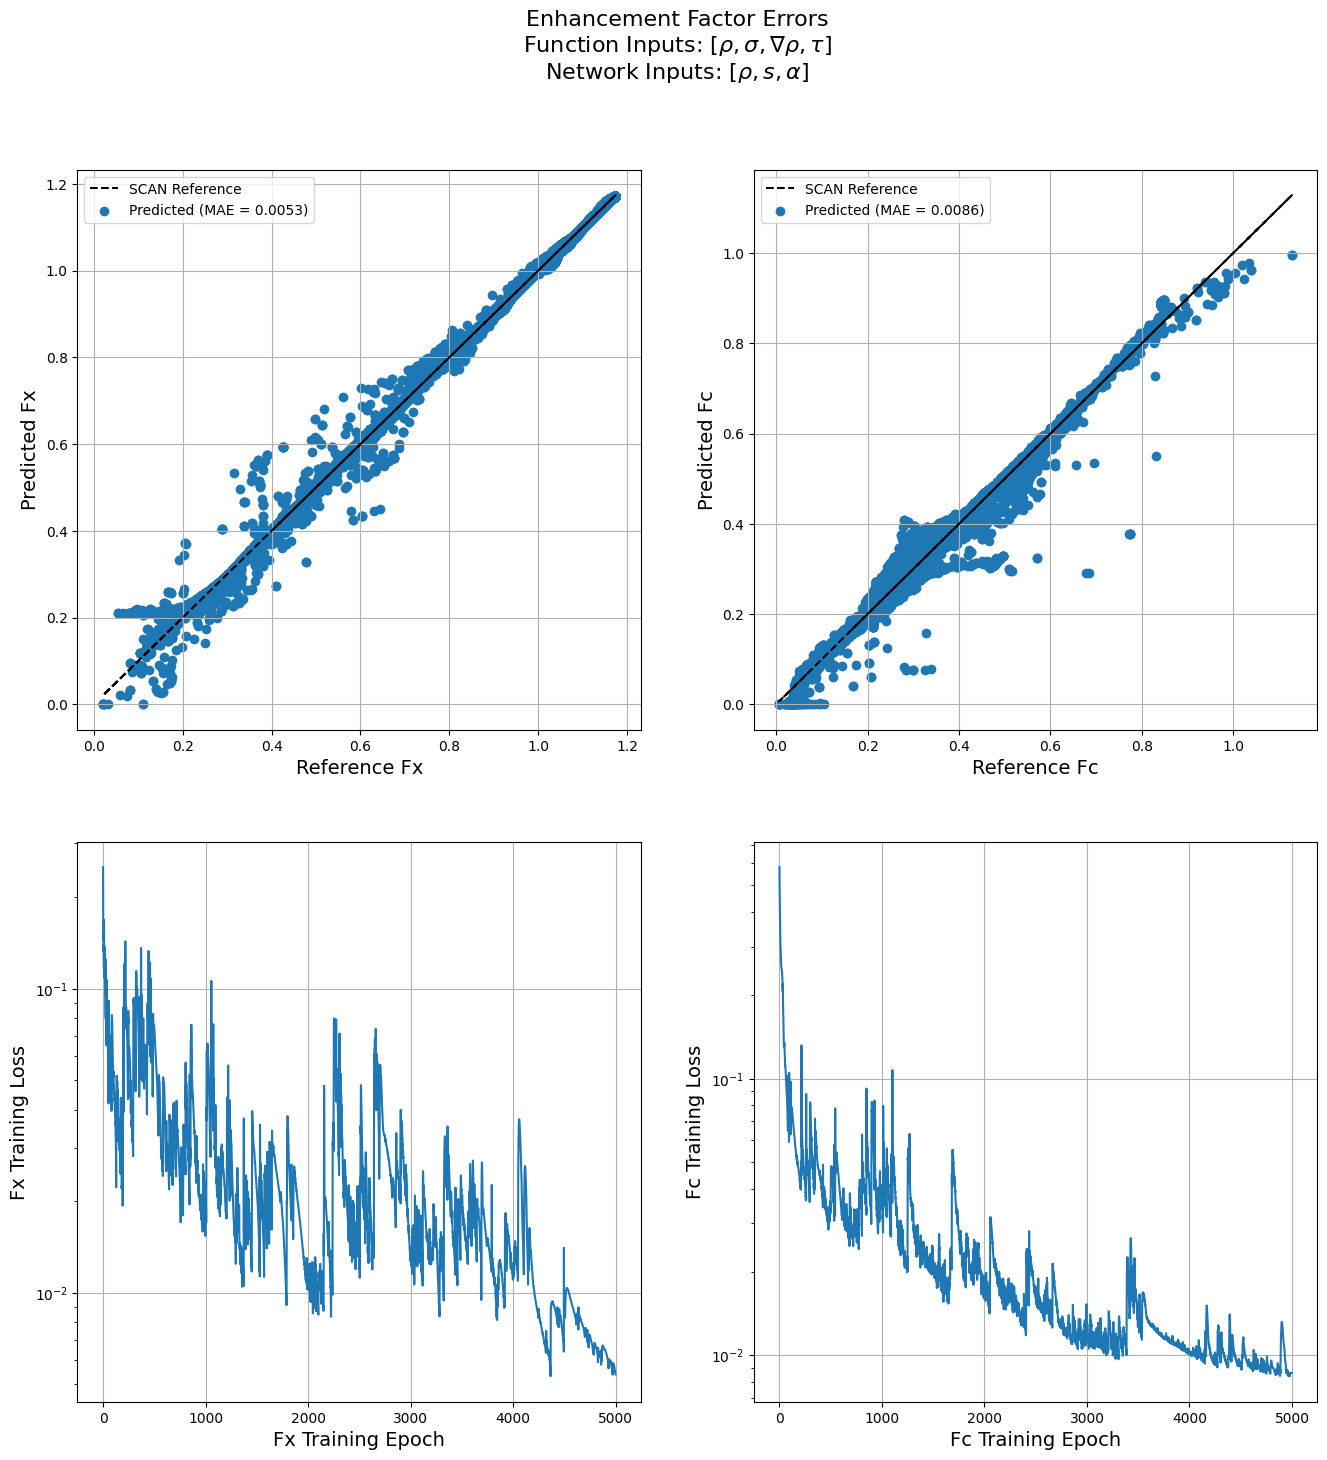

In [25]:
f = plt.figure(figsize=(16,16))
axx = f.add_subplot(221)
axc = f.add_subplot(222)
axxl = f.add_subplot(223)
axcl = f.add_subplot(224)

axx.plot(test_ref_Fx, test_ref_Fx, 'k--', label='SCAN Reference')
axc.plot(test_ref_Fc, test_ref_Fc, 'k--', label='SCAN Reference')

axx.scatter(test_ref_Fx, test_pred_fx, label='Predicted (MAE = {:3.4f})'.format(fx_mae))
axc.scatter(test_ref_Fc, test_pred_fc, label='Predicted (MAE = {:3.4f})'.format(fc_mae))

axxl.plot(np.arange(0, OPTSTEPS), nlx)
axcl.plot(np.arange(0, OPTSTEPS), nlc)

axx.legend()
axc.legend()

axx.set_xlabel('Reference Fx', fontsize=14)
axx.set_ylabel('Predicted Fx', fontsize=14)
axxl.set_xlabel('Fx Training Epoch', fontsize=14)
axxl.set_ylabel('Fx Training Loss', fontsize=14)

axc.set_xlabel('Reference Fc', fontsize=14)
axc.set_ylabel('Predicted Fc', fontsize=14)
axcl.set_xlabel('Fc Training Epoch', fontsize=14)
axcl.set_ylabel('Fc Training Loss', fontsize=14)

axxl.set_yscale('log')
axcl.set_yscale('log')

axx.grid()
axc.grid()
axxl.grid()
axcl.grid()

plt.suptitle('Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\rho,s,\\alpha$]',fontsize=16)

Text(0.5, 0.98, 'Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\tilde{x}_0,\\tilde{x}_2,\\tilde{x}_3$]')

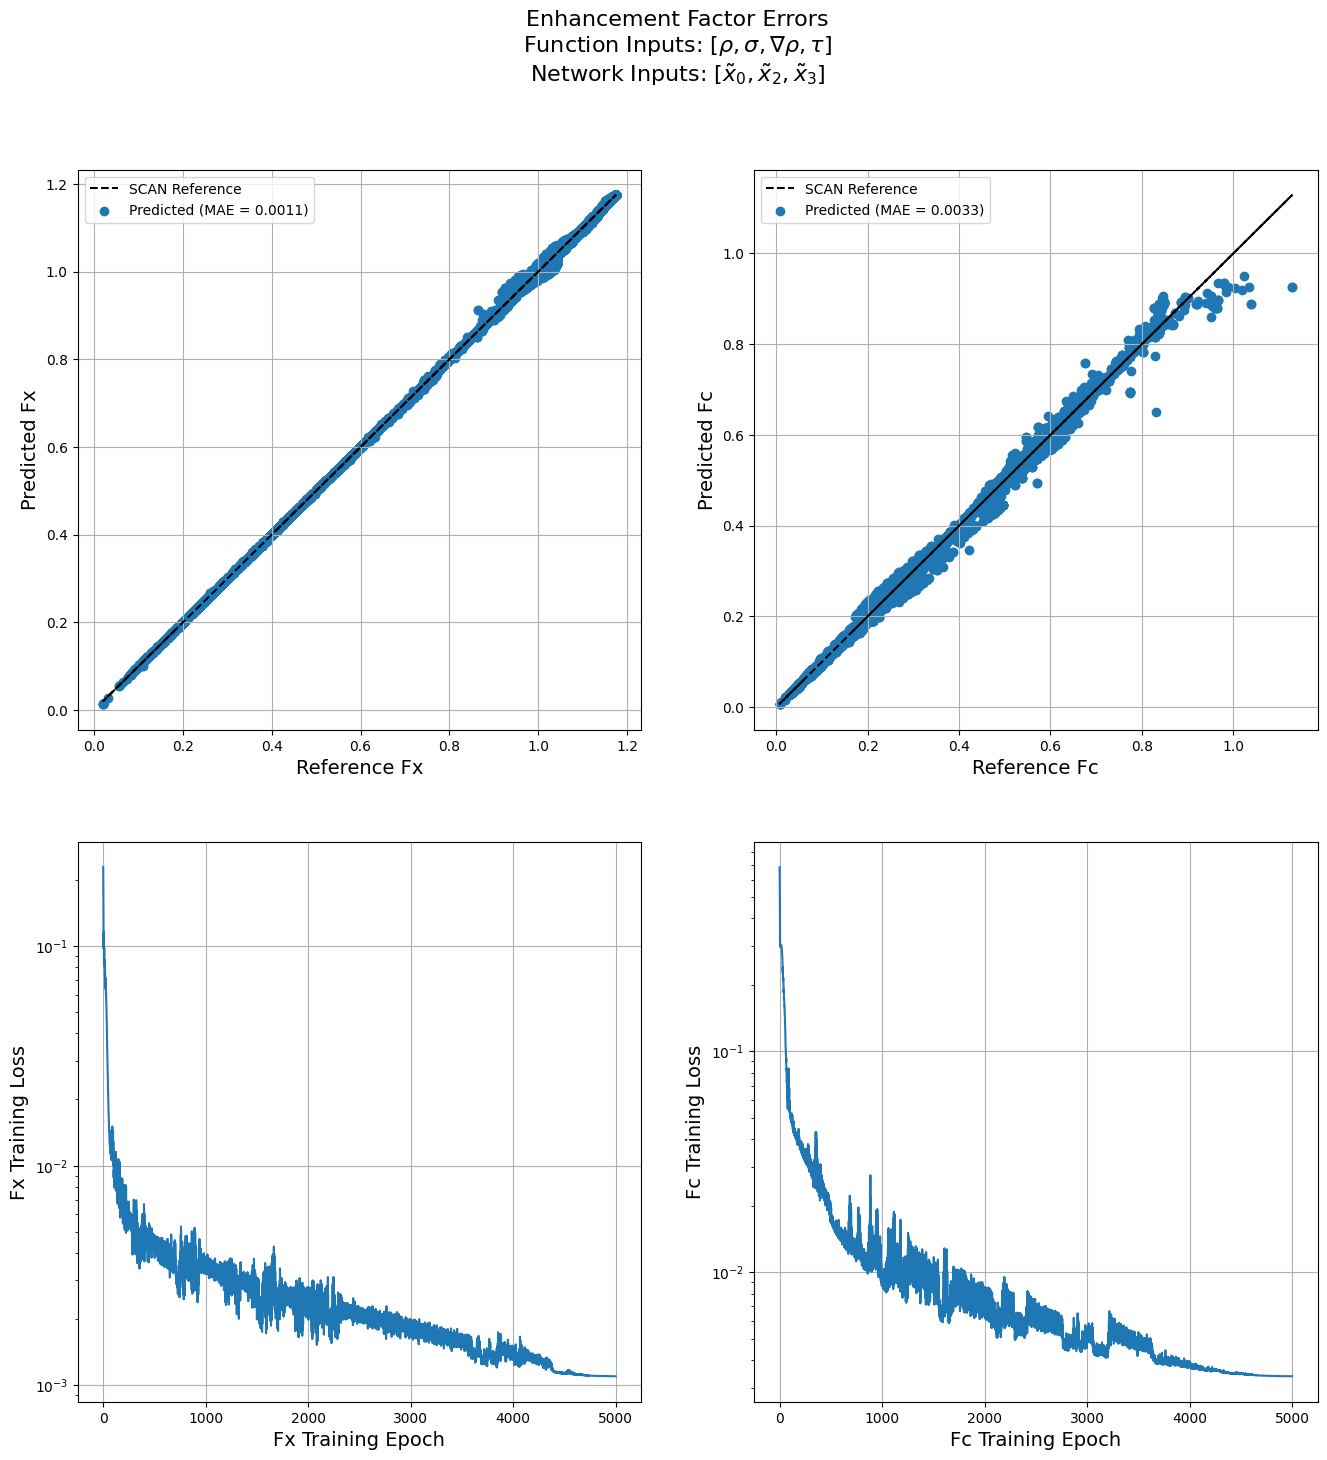

In [26]:
f = plt.figure(figsize=(16,16))
axx = f.add_subplot(221)
axc = f.add_subplot(222)
axxl = f.add_subplot(223)
axcl = f.add_subplot(224)

axx.plot(test_ref_Fx, test_ref_Fx, 'k--', label='SCAN Reference')
axc.plot(test_ref_Fc, test_ref_Fc, 'k--', label='SCAN Reference')

axx.scatter(test_ref_Fx, test_pred_fxt, label='Predicted (MAE = {:3.4f})'.format(fxt_mae))
axc.scatter(test_ref_Fc, test_pred_fct, label='Predicted (MAE = {:3.4f})'.format(fct_mae))

axxl.plot(np.arange(0, OPTSTEPS), nlxt)
axcl.plot(np.arange(0, OPTSTEPS), nlct)

axx.legend()
axc.legend()

axx.set_xlabel('Reference Fx', fontsize=14)
axx.set_ylabel('Predicted Fx', fontsize=14)
axxl.set_xlabel('Fx Training Epoch', fontsize=14)
axxl.set_ylabel('Fx Training Loss', fontsize=14)

axc.set_xlabel('Reference Fc', fontsize=14)
axc.set_ylabel('Predicted Fc', fontsize=14)
axcl.set_xlabel('Fc Training Epoch', fontsize=14)
axcl.set_ylabel('Fc Training Loss', fontsize=14)

axxl.set_yscale('log')
axcl.set_yscale('log')

axx.grid()
axc.grid()
axxl.grid()
axcl.grid()

plt.suptitle('Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\tilde{x}_0,\\tilde{x}_2,\\tilde{x}_3$]',fontsize=16)

# Optimization Example

NaNs appearing in forward pass -- investigate.

In [27]:
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-6
OPTSTEPS = 1000
OPTDECAYBEGIN = int(OPTSTEPS/5)
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)

#create optimizers
optimizer = optax.chain(
    optax.adam(learning_rate=scheduler)
)

s_scan_fx_tr2 = net_Sara.MGGA_FxNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc_tr2 = net_Sara.MGGA_FcNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
pt_scan_fxt = Pretrainer(model = s_scan_fx_tr2, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fct = Pretrainer(model = s_scan_fc_tr2, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

In [28]:
nmxt2, nlxt2 = pt_scan_fxt()
nmct2, nlct2 = pt_scan_fct()

Epoch 0: Loss = 0.22894097966076402
Epoch 100: Loss = 0.010019161963171319
Epoch 200: Loss = 0.00815147093245637
Epoch 300: Loss = 0.0058262043744531115
Epoch 400: Loss = 0.004222590894303262
Epoch 500: Loss = 0.003628038119570391
Epoch 600: Loss = 0.003237756814054855
Epoch 700: Loss = 0.0025105301996228855
Epoch 800: Loss = 0.0024265775069109
Epoch 900: Loss = 0.00226434100353918
Epoch 0: Loss = 0.6827698301834336
Epoch 100: Loss = 0.05240499581950469
Epoch 200: Loss = 0.03684326377517516
Epoch 300: Loss = 0.030187067219597224
Epoch 400: Loss = 0.024191877532992883
Epoch 500: Loss = 0.02000033601055129
Epoch 600: Loss = 0.01505512661711028
Epoch 700: Loss = 0.01355482992450596
Epoch 800: Loss = 0.012505740471595111
Epoch 900: Loss = 0.011999121694301666


Start with a CCSD water molecule calculation.

In [30]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
mf = dft.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()
start_hf = scf.RHF(mol)
start_hf.kernel()
cc_h2o = cc.CCSD(start_hf)
cc_h2o.kernel()
#generate CCSD density using DFT coordinates and CCSD density matrix.
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
ccsd_dm = cc_h2o.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, ccsd_dm, xctype='MGGA')
target_rho = jnp.array(rho[0]).flatten()

In [31]:
cc_h2o.e_tot, mf.e_tot, rho.shape, target_rho.shape

(-76.24010891900588, -76.33342437818293, (6, 9088), (9088,))

In [32]:
TARGET_ENERGY = cc_h2o.e_tot

Define the function we will overwrite the default `eval_xc` with.

In [ ]:
def eval_xc_mgga_j(xc_code, rho, spin=0, relativity=0, deriv=2, omega=None, verbose=None,
                 xcmodel = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    try:
        rho0, dx, dy, dz, lapl, tau = rho[:6]
        sigma = jnp.array(dx**2+dy**2+dz**2)
    except:
        rho0, drho, lapl, tau = rho[:4]
        sigma = jnp.array(drho**2)
    rho0 = jnp.array(rho0)
    net_inp = jnp.stack([rho0.flatten(), sigma.flatten(), lapl.flatten(), tau.flatten()], axis=1)
    # print(net_inp.shape)
    #calculate the "custom" energy with rho -- THIS IS EPSILON -- network constructed to give this, so divide by rho0
    exc = jax.vmap(xcmodel)(net_inp)
    # print('epsilon: ', exc, 'rho0: ', rho0)
    exc = exc / rho0
    # print('exc: ', exc)
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(xcmodel)
    v1 = jnp.array(jax.vmap(vrho_f)( net_inp ))
    # print('v1 shape:', v1.shape)
    # print('v1:', v1)
    vxc = (v1[:, 0], v1[:, 1], v1[:, 2], v1[:, 3])

    v2_f = jax.hessian(xcmodel)
    v2 = jnp.array(jax.vmap(v2_f)( net_inp ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[:, 0, 0]
    v2rhosigma = v2[:, 0, 1]
    v2sigma2 = v2[:, 1, 1]
    v2lapl2 = v2[:, 2, 2]
    vtau2 = v2[:, 3, 3]
    v2rholapl = v2[:, 0, 2]
    v2rhotau = v2[:, 0, 3]
    v2lapltau = v2[:, 2, 3]
    v2sigmalapl = v2[:, 1, 2]
    v2sigmatau = v2[:, 1, 3]
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    

    return exc, vxc, fxc, kxc

In [ ]:
model = xc.RXCModel_MGGA(xnet = nmxt2, cnet = nmct2)

In [ ]:
mol = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
mol.build()
mfn = dft_ad.RKS(mol)
mfn.grids.level = 1
custom_eval_xc = partial(eval_xc_mgga_j, xcmodel=model)
mfn.define_xc_(custom_eval_xc, 'MGGA')
mfn.kernel()

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking deriv

Array(-76.40474192, dtype=float64)

In [ ]:
ao = dft.numint.eval_ao(mol, mfn.grids.coords, deriv=2)
target_rho = dft_ad.numint.eval_rho(mol, jnp.array(ao), jnp.array(ccsd_dm), xctype='MGGA')

To demonstrate what one could do to include density in the training, we optimize against the H2O total energy and density, using the CCSD density as reference.

In [ ]:
mol.nelectron, target_rho.shape

(10, (6, 9082))

In [ ]:
@eqx.filter_value_and_grad
def opt_loss_TE(model, mols, refs):
    #here, mols = [h2o]; refs = [[h2o_TE, ref_rho]]; but don't use rho info
    total_loss = 0
    TE_loss = 0
    rho_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_mgga_j, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'MGGA')
        mf.kernel()
        TE_loss += abs(mf.e_tot - refs[idx][0])
        total_loss += TE_loss
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss_TE_rho(model, mols, refs):
    #here, mols = [h2o]; refs = [[h2o_TE, ref_rho]]
    total_loss = 0
    TE_loss = 0
    rho_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_mgga_j, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'MGGA')
        mf.kernel()
        TE_loss += abs(mf.e_tot - refs[idx][0])
        ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
        dm = mf.make_rdm1()
        rho = dft_ad.numint.eval_rho(mol, jnp.array(ao), dm, xctype='MGGA')[0].flatten()
        rho_loss += (1/mol.nelectron)*jnp.sum(mf.grids.weights*jnp.sqrt((rho - refs[idx][1])**2))
        #i weight here the density loss more heavily
        total_loss += TE_loss + 20*rho_loss
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

In [ ]:
OPT_INIT_LR = 5e-2
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 30
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt = optax.adam(learning_rate=scheduler)
opt_mgga_te = Optimizer(model=model, optim=opt_opt, mols = [mol], refs = [[TARGET_ENERGY, target_rho]], loss=opt_loss_TE, print_every=1, steps=OPTSTEPS)

opt_mgga_terho = Optimizer(model=model, optim=opt_opt, mols = [mol], refs = [[TARGET_ENERGY, target_rho]], loss=opt_loss_TE_rho, print_every=1, steps=OPTSTEPS)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#a lot of "derivative wrt the leaves not taken" printouts from pyscfad -- suppress that so we can actually see the losses easily

In [ ]:
opt_te_rho, opt_te_rho_loss = opt_mgga_terho()

Epoch 0: Loss = 1043.400229232905
Epoch 1: Loss = 1043.3076454203028
Epoch 2: Loss = 1043.0952729627475
Epoch 3: Loss = 1043.0974913009945
Epoch 4: Loss = 1043.0077484057474
Epoch 5: Loss = 1042.805163462421
Epoch 6: Loss = 1042.8505201400274
Epoch 7: Loss = 1042.899687848223
Epoch 8: Loss = 1042.8923117552
Epoch 9: Loss = 1042.8994218796788
Epoch 10: Loss = 1042.7459534104214
Epoch 11: Loss = 1042.7526029751534
Epoch 12: Loss = 1043.177420780713
Epoch 13: Loss = 1043.1657094227364
Epoch 14: Loss = 1043.1553301415931
Epoch 15: Loss = 1043.1216778402138
Epoch 16: Loss = 1043.088570802894
Epoch 17: Loss = 1043.0590988440492
Epoch 18: Loss = 1043.0347326159253
Epoch 19: Loss = 1043.0172627034592
Epoch 20: Loss = 1043.0075392634444
Epoch 21: Loss = 1043.004607879826
Epoch 22: Loss = 1043.0061761001102
Epoch 23: Loss = 1043.0101110411056
Epoch 24: Loss = 1043.016149568988
Epoch 25: Loss = 1043.0281182320066
Epoch 26: Loss = 1043.0494928813903
Epoch 27: Loss = 1043.0783865998142
Epoch 28: Lo

In [ ]:
opt_te, opt_te_loss = opt_mgga_te()

Epoch 0: Loss = 0.1646329974354046
Epoch 1: Loss = 0.756376179539231
Epoch 2: Loss = 0.45657680468973183
Epoch 3: Loss = 0.13750677062249395
Epoch 4: Loss = 0.08852245609493536
Epoch 5: Loss = 0.15430771815299238
Epoch 6: Loss = 0.15460175051192948
Epoch 7: Loss = 0.12342237460244121
Epoch 8: Loss = 0.0684332662684426
Epoch 9: Loss = 0.017990290857611058
Epoch 10: Loss = 0.030164596946562483
Epoch 11: Loss = 0.0012330828387518977
Epoch 12: Loss = 0.002597192710069862
Epoch 13: Loss = 0.01829887559803467
Epoch 14: Loss = 0.01622538008321328
Epoch 15: Loss = 0.0033833450519153985
Epoch 16: Loss = 0.0013368169794176765
Epoch 17: Loss = 0.01700917152520276
Epoch 18: Loss = 0.018192217386058473
Epoch 19: Loss = 0.005969437957631385
Epoch 20: Loss = 0.02014262455659832
Epoch 21: Loss = 0.027032232969219194
Epoch 22: Loss = 0.016005708251910278
Epoch 23: Loss = 0.006621179124223886
Epoch 24: Loss = 0.013779293363953116
Epoch 25: Loss = 0.00993352408133319
Epoch 26: Loss = 0.00398864321132919


Examine results

Text(0, 0.5, 'Loss [Total Energy]')

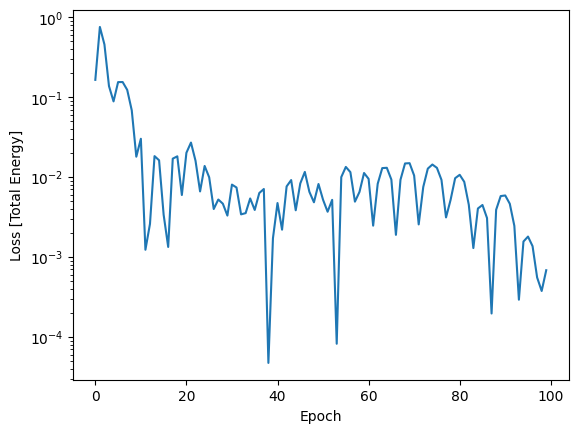

In [ ]:
plt.plot(opt_te_loss, label='Opt[TE]')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel("Loss [Total Energy]")

Text(0, 0.5, 'Loss [Total Energy + Rho]')

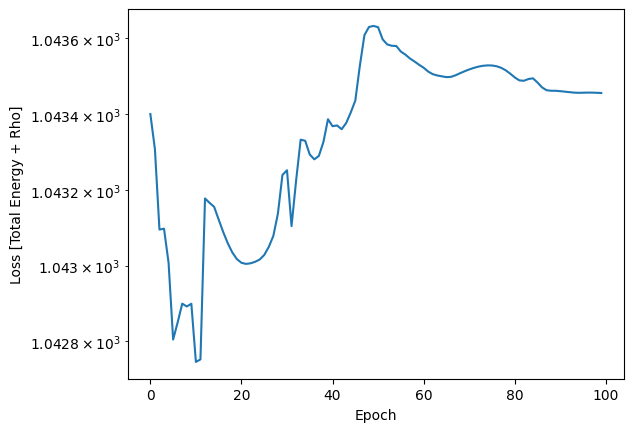

In [ ]:
plt.plot(opt_te_rho_loss, label='Opt[TE+Rho]')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel("Loss [Total Energy + Rho]")

Something is going wrong in the density learning, we will need to see what.

In [ ]:
w27systems = {
    'OHmH2O4c4' : { 'atoms' : ['H', 'H', 'H', 'H', 'O', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0267918, 1.5818251, 0.2834249], [1.5818251, 0.0267918, 0.2834249], [0.0267918, -1.5818251, 0.2834249], [-1.5818251, -0.0267918, 0.2834249], [0.0, 0.0, 0.9578999], [0.0, 0.0, 1.9177035], [0.0314199, 2.4185664, -0.2529905], [2.4185664, -0.0314199, -0.2529905], [-0.0314199, -2.4185664, -0.2529905], [-2.4185664, 0.0314199, -0.2529905], [0.843048, 2.2785225, -0.7493353], [2.2785225, -0.843048, -0.7493353], [-0.843048, -2.2785225, -0.7493353], [-2.2785225, 0.843048, -0.7493353]], 'charge' : -1, 'spin' : 0 },
    'H2O8d2d' : { 'atoms' : ['O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.4645552, -1.4645552, 1.3497067], [-1.4645552, 1.4645552, -1.3497067], [1.4645552, -1.4645552, -1.3497067], [1.4645552, 1.4645552, 1.3497067], [-1.5346654, -1.5346654, 0.3622554], [-1.5346654, 1.5346654, -0.3622554], [1.5346654, -1.5346654, -0.3622554], [1.5346654, 1.5346654, 0.3622554], [-2.0896636, -2.0896636, 1.7251112], [-2.0896636, 2.0896636, -1.7251112], [2.0896636, -2.0896636, -1.7251112], [2.0896636, 2.0896636, 1.7251112], [-1.4052886, -1.4052886, -1.3390082], [-1.4052886, 1.4052886, 1.3390082], [1.4052886, -1.4052886, 1.3390082], [1.4052886, 1.4052886, -1.3390082], [-1.5526158, -0.4620645, -1.5268989], [-1.5526158, 0.4620645, 1.5268989], [1.5526158, -0.4620645, 1.5268989], [-0.4620645, -1.5526158, -1.5268989], [0.4620645, 1.5526158, -1.5268989], [0.4620645, -1.5526158, 1.5268989], [-0.4620645, 1.5526158, 1.5268989], [1.5526158, 0.4620645, -1.5268989]], 'charge' : 0, 'spin' : 0 },
    'H2O20es' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.4449507, -2.3192362, 1.3852172], [0.9523409, -1.4842602, 1.5288696], [2.3694569, -2.1139495, 1.6116655], [1.4198689, -2.4626094, -1.4007113], [1.4412349, -2.4945724, -0.4194091], [0.7771617, -3.1468464, -1.6575718], [0.0068371, 0.0172196, 1.4027157], [0.3893324, 0.9065634, 1.5625403], [-0.9609503, 0.0503272, 1.5609821], [-2.7367283, -0.0717073, 1.3588421], [-2.7881947, -0.0946107, 0.3779034], [-2.9785985, -0.9717563, 1.6413949], [4.0454641, 1.4627919, -1.4612681], [4.7881071, 1.7639854, -1.9912934], [4.0333238, 0.4731882, -1.5313495], [-1.0008037, 4.2249605, 1.4982864], [-1.152189, 5.0082615, 2.0335617], [-1.8328395, 3.6856129, 1.5416327], [-3.2272404, 2.7492225, -1.5453255], [-3.8412573, 3.2117349, -2.121788], [-2.3703373, 3.2485931, -1.5888707], [0.061546, -0.0608668, -1.3504788], [0.5404095, -0.8892136, -1.5688996], [0.0525024, -0.0517312, -0.3661063], [1.3505765, 2.3624375, -1.4255501], [2.2943427, 2.2180386, -1.6165285], [0.9255618, 1.4877943, -1.5595341], [4.0797114, -1.2705898, 1.5101742], [4.8184302, -1.5307198, 2.0667554], [4.0088205, -0.2833084, 1.5792807], [-0.9118416, 4.114684, -1.3968277], [-0.8699572, 4.3289684, -0.4493559], [-0.0897473, 3.6305502, -1.5859742], [-2.6850195, -0.0424816, -1.4274401], [-2.9831436, 0.8560006, -1.6562177], [-1.7132338, -0.0438086, -1.5635337], [-3.1295491, -2.8665515, -1.3299376], [-3.1140901, -1.9191429, -1.5480976], [-3.3032413, -2.9025862, -0.3736924], [1.224434, 2.4780105, 1.3595377], [0.5812433, 3.1657978, 1.6076146], [1.272843, 2.5161003, 0.3793006], [-0.812813, -4.2331318, -1.5239325], [-0.9466607, -5.0213678, -2.0566534], [-1.663369, -3.7232425, -1.5543692], [-3.2498861, 2.7544587, 1.3479831], [-3.1924627, 1.8120206, 1.5790401], [-3.4347595, 2.7666931, 0.3928574], [4.0373837, -1.2313563, -1.3812425], [3.2335259, -1.7195098, -1.6240819], [4.1604036, -1.4012254, -0.4312943], [-3.094015, -2.885118, 1.5661544], [-2.2180185, -3.3510614, 1.5943976], [-3.6898242, -3.3867826, 2.1285951], [-0.7332536, -4.1659349, 1.3697764], [0.0709231, -3.6538397, 1.5619151], [-0.6879895, -4.3597798, 0.4176959], [3.9098072, 1.4164687, 1.4257218], [3.0660482, 1.8495739, 1.636771], [4.0554225, 1.5928403, 0.4801529]], 'charge' : 0, 'spin' : 0 },
    'H2O20fs' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-0.4674337, -1.4156432, 2.3424832], [-0.5103881, -0.5327785, 2.7383509], [-1.154371, -1.4135419, 1.6390602], [-1.1804953, -4.411489, -2.0217879], [-1.6005951, -5.0804995, -2.5684061], [-1.6296589, -4.4443491, -1.1306922], [-0.3890822, -4.3416186, 2.3649217], [-0.4122318, -3.4254374, 2.6780297], [0.495447, -4.4516812, 1.9766411], [-2.370827, -1.4010748, 0.3317388], [-2.7687053, -0.5190604, 0.3764393], [-1.9008133, -1.4312776, -0.5314561], [-1.0412215, -1.5773429, -2.0898648], [-0.0740952, -1.5478577, -1.9182976], [-1.2210828, -2.5028893, -2.3334269], [1.6403031, -4.3519848, -1.6030968], [0.6907637, -4.4791178, -1.78646], [1.8234428, -3.4332488, -1.8548591], [-2.332464, -4.3191108, 0.3710663], [-1.6749165, -4.4161499, 1.0945673], [-2.663344, -3.4130595, 0.4587135], [1.6787401, -1.4676579, -1.5895498], [1.8042491, -1.4683808, -0.6135222], [1.9691284, -0.5921861, -1.8871045], [2.0177788, -1.5700244, 1.1457336], [1.1343262, -1.5367783, 1.5764315], [2.3187166, -2.4899023, 1.2541941], [2.1824622, -4.3930741, 1.0311736], [2.8554348, -5.0463468, 1.2384494], [2.0031126, -4.4627308, 0.0573709], [-0.4152401, 4.3842505, 2.2876138], [-0.5679834, 5.06537, 2.9479304], [-1.1127701, 4.487654, 1.6038264], [-1.1046614, 1.2760042, -2.0786808], [-1.2737935, 0.3860585, -2.4278927], [-1.5421398, 1.2973941, -1.1984656], [-0.3343417, 1.482161, 2.3157837], [0.5348035, 1.4101401, 1.8606636], [-0.3797162, 2.3986009, 2.6294913], [-2.2749913, 4.3768946, 0.233996], [-1.7988517, 4.3462894, -0.6427551], [-2.9812564, 5.0213482, 0.1371479], [-0.9933823, 4.1431644, -2.0843627], [-0.0298852, 4.2701065, -2.0022747], [-1.1087883, 3.2216193, -2.3688039], [1.6344386, 1.3954288, -1.6918288], [0.6638061, 1.3608461, -1.8412994], [1.8936812, 2.3076806, -1.9040298], [-2.3215084, 1.4785163, 0.3929266], [-2.6250091, 2.4001087, 0.3878313], [-1.6192612, 1.4525318, 1.0812056], [1.8145415, 4.2491098, -1.649936], [2.4020909, 4.8900295, -2.0585139], [1.9809374, 4.28431, -0.6721155], [2.1692949, 4.1320169, 1.0124794], [2.3810198, 3.2011114, 1.193355], [1.3372868, 4.3008339, 1.4866278], [2.0958108, 1.2695995, 1.0227267], [2.4183264, 0.3768526, 1.2284758], [1.9353623, 1.2702628, 0.0520364]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-1.1997281, 0.0290201, 0.115747], [-1.6314241, -0.7333199, 0.5284065], [-1.6940017, 0.2956236, -0.6724225], [1.1997281, -0.0290201, 0.115747], [0.0, 0.0, 0.056538], [1.6940017, -0.2956236, -0.6724225], [1.6314241, 0.7333199, 0.5284065]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O4cs' : { 'atoms' : ['O', 'O', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[0.7941268, -0.1580495, 2.0660393], [-0.026599, -1.4686255, 0.0], [0.8535437, 1.317568, 0.7632695], [-0.0492092, 0.0556879, 2.4738562], [0.7060196, 1.9061093, 0.0], [0.8535437, 1.317568, -0.7632695], [0.7941268, -0.1580495, -2.0660393], [-0.0492092, 0.0556879, -2.4738562], [0.5253029, -0.7667811, -1.2898742], [-2.0377301, 0.3905888, 0.0], [-1.3911533, 1.1099929, 0.0], [-1.4545847, -0.4079553, 0.0], [0.5253029, -0.7667811, 1.2898742], [-0.0434809, -2.4269609, 0.0]], 'charge' : -1, 'spin' : 0 },
    'H3Op' : { 'atoms' : ['O', 'H', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.2080105], [0.4697566, 0.8136422, 0.0693368], [0.4697566, -0.8136422, 0.0693368], [-0.9395131, 0.0, 0.0693368]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O2' : { 'atoms' : ['H', 'O', 'H', 'H', 'O', 'H', 'O', 'H'], 'coords' : [[-1.4579587, 0.0040843, 0.0244594], [-2.4291204, 0.0733055, -0.3263151], [0.0, 0.0, 1.4813683], [-2.4564986, 0.9567436, -0.699417], [0.0, 0.0, 0.5211771], [1.4579587, -0.0040843, 0.0244594], [2.4291204, -0.0733055, -0.3263151], [2.4564986, -0.9567436, -0.699417]], 'charge' : -1, 'spin' : 0 },
    'H2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.3305065, 0.9990741, 0.0], [-1.0635455, 1.9210871, 0.0], [-0.5051326, 0.4919421, 0.0], [1.0052144, -0.7512682, 0.0], [0.9469851, -1.3304176, -0.7655752], [0.9469851, -1.3304176, 0.7655752]], 'charge' : 0, 'spin' : 0 },
    'H2O6c' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-2.126243, 0.9197498, 1.8264958], [-2.1881222, 1.4620146, 2.6158476], [-1.5986358, 1.4265182, 1.1737716], [-0.6242004, -1.3533166, 1.1757103], [-1.1988054, -0.6794287, 1.5877759], [0.2729833, -0.9963075, 1.2645231], [1.8287624, 0.1754817, 0.6422639], [2.0392499, -0.2029455, -0.2401564], [2.6632512, 0.2979341, 1.1013749], [-0.8422995, -0.8438539, -1.4490439], [-1.5454762, -1.316182, -1.9016515], [-0.8613423, -1.1366364, -0.4986366], [-0.4537151, 1.8328264, -0.1915392], [-0.7281657, 1.1638105, -0.8364546], [0.4013688, 1.5054304, 0.1303423], [1.8922043, -0.9099854, -1.8706972], [2.1537551, -0.3720142, -2.6222492], [0.9154307, -0.9730955, -1.9076768]], 'charge' : 0, 'spin' : 0 },
    'H2O20' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.5972952, 3.6342929, 0.1165628], [3.4570031, 1.5457807, 0.8715044], [-0.57424, 3.488956, 1.7956375], [0.6295601, 2.9030991, -2.4803288], [2.562887, 0.2380423, 2.9758015], [-0.0061254, 1.3030904, 3.6250687], [3.6694758, -0.1920224, -1.2507983], [-2.6588176, 2.7244506, 0.3711345], [1.9365179, 0.5910602, -3.3888087], [-1.9819526, 2.4899264, -2.3389977], [2.0356643, -2.4018164, 2.1787274], [-1.8845792, -0.6687213, 3.2997576], [2.7932149, -2.7984187, -0.3020458], [-3.7135037, 0.2090327, 1.2262852], [0.1062725, -1.293281, -3.6485737], [-2.3812958, -0.2589936, -3.0530727], [-0.7279685, -2.9024551, 2.5515924], [0.5941514, -3.461153, -1.784129], [-3.4834248, -1.6651538, -0.76021], [-1.6647964, -3.4265588, -0.0388993], [0.8366572, 3.6498, 0.7406949], [1.9869746, 4.5126507, 0.1363602], [2.8531582, 2.2552477, 0.5991012], [3.5564427, 0.9528663, 0.092497], [-0.860346, 4.2574733, 2.2971151], [-1.3676155, 3.1980612, 1.2597142], [1.0058172, 3.1354291, -1.6140348], [1.1176189, 2.1179309, -2.7977873], [3.2218852, 0.3339645, 3.6687595], [2.917311, 0.736237, 2.1825883], [0.8868802, 0.970391, 3.4227382], [-0.1583775, 2.0479994, 3.0212474], [3.3730831, -1.0735747, -0.971529], [3.1050897, 0.053996, -2.005135], [-2.4656562, 2.6610551, -0.5848248], [-3.0302259, 1.8642237, 0.6349499], [1.2448937, -0.1226649, -3.5032296], [2.3685947, 0.68444, -4.2421884], [-2.3988056, 3.1036186, -2.9499344], [-0.9990854, 2.6509609, -2.4091562], [1.089413, -2.5673533, 2.3485271], [2.2199554, -1.4937765, 2.4901053], [-2.5067142, -0.3437261, 2.6291954], [-1.2285821, 0.0523333, 3.4406625], [3.5521661, -3.3866115, -0.2562954], [2.5019631, -2.6479144, 0.6464344], [-4.6222885, 0.2638838, 1.5345724], [-3.6996256, -0.472578, 0.5153993], [0.251188, -2.0333038, -3.037317], [-0.7962964, -0.9523111, -3.4593251], [-2.2861386, 0.6788768, -2.8115617], [-2.7753977, -0.6983972, -2.2822631], [-0.9190239, -3.559496, 3.2264945], [-1.1717496, -2.0542602, 2.8528846], [0.7227644, -4.3091097, -2.2179802], [1.4210061, -3.2760638, -1.2803666], [-4.2486672, -2.1741634, -1.0420466], [-2.790722, -2.3358781, -0.4884945], [-0.8844205, -3.4528625, -0.6209771], [-1.3284624, -3.2865515, 0.8681973]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O' : { 'atoms' : ['H', 'H', 'O', 'O', 'H'], 'coords' : [[-0.0913883, -0.2448128, 0.0130826], [1.5272733, 0.3383121, 0.6525543], [-1.2208378, -0.2356182, 0.0613147], [1.2462132, -0.220611, -0.0771381], [-1.4612604, 0.3627299, -0.6498135]], 'charge' : -1, 'spin' : 0 },
    'H2O6b' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[0.1144839, 1.5112333, 0.843513], [0.9588057, 1.471558, 0.3295002], [0.261291, 2.1241091, 1.5685011], [-0.0281704, -1.4370823, 0.9851182], [-0.0383127, -0.486232, 1.1718938], [-0.8642499, -1.5983938, 0.5055884], [-2.3537981, 1.3280181, -0.4618208], [-1.4871423, 1.5019404, -0.0453109], [-2.3472534, 1.794165, -1.3012567], [-2.4676711, -1.4576027, -0.4185461], [-2.5397542, -0.4850372, -0.4964169], [-3.26029, -1.745642, 0.0408062], [2.4264495, 1.14816, -0.4958637], [2.4838349, 0.1618456, -0.5091494], [2.5261922, 1.4338488, -1.4071863], [2.2762914, -1.5490049, -0.4262672], [1.4225637, -1.6349539, 0.0649769], [2.9167296, -2.0809295, 0.0519201]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4488552, 2.4506609, -0.112838], [0.5365645, 3.1082364, 0.5858367], [0.9587367, 2.7678608, -0.865725], [-2.3467622, -0.8366105, -0.112838], [-2.8764061, -0.55364, -0.865725], [-2.9600939, -1.0894397, 0.5858367], [1.897907, -1.6140505, -0.112838], [2.4235294, -2.0187966, 0.5858367], [1.9176694, -2.2142207, -0.865725], [0.0, 0.0, 0.4980372], [0.7206738, -0.6586452, 0.2267139], [0.2100666, 0.9534444, 0.2267139], [-0.9307403, -0.2947992, 0.2267139]], 'charge' : 1, 'spin' : 0 },
    'H2O5' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.1268024, -1.5421147, 1.3115375], [-0.7661903, -2.0208888, 2.0619128], [-1.0425473, -0.5875811, 1.5375504], [0.0803781, -2.0408214, -1.0866271], [-0.5297873, -2.5676517, -1.6076619], [-0.3615744, -1.8901965, -0.2198678], [0.8653564, 2.1577269, -0.0051264], [0.9896838, 1.5118344, -0.7375001], [1.7477174, 2.4024394, 0.2841736], [-0.7980209, 1.1055424, 1.8833964], [-0.1925383, 1.5158527, 1.2242825], [-1.5800472, 1.6620636, 1.9082724], [1.1675335, 0.3103577, -1.9923084], [0.7679385, 0.5364348, -2.8354387], [0.7789005, -0.5529975, -1.7265952]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H'], 'coords' : [[0.2309966, -1.7501603, -1.6137318], [0.3547704, -1.4268652, -2.5095198], [-0.4863599, -1.1511869, -1.2247679], [-0.8187277, -1.8096257, 1.5257334], [-0.3247737, -2.4623293, 1.0212858], [-1.1694889, -1.1908734, 0.8176224], [-0.9356309, 2.0631218, 1.0559169], [-1.2826168, 1.254229, 0.5973567], [-0.4402953, 2.4787494, 0.3372993], [1.0346387, 0.3062362, 2.1888664], [0.4723616, -0.4881286, 2.1220177], [0.4232868, 1.0226881, 1.9283641], [0.2656542, 1.7374371, -1.6823817], [1.0715576, 1.3171856, -1.3358043], [-0.4373017, 1.1167995, -1.3960602], [2.2703738, -0.0203258, -0.4001794], [1.9574443, 0.1070627, 0.5173217], [1.69198, -0.7185752, -0.7539803], [-1.4854286, -0.1445915, -0.4478202], [-2.3924405, -0.2408477, -0.7475386]], 'charge' : -1, 'spin' : 0 },
    'H2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.1847029, 1.1150792, -0.0344641], [0.4939088, 0.9563767, 0.6340089], [2.0242676, 1.0811246, 0.4301417], [-1.1469443, 0.0697649, 1.1470196], [-1.2798308, -0.5232169, 1.8902833], [-1.0641398, -0.4956693, 0.356925], [-0.1633508, -1.0289346, -1.2401808], [0.4914771, -0.3248733, -1.0784838], [-0.5400907, -0.8496512, -2.1052499]], 'charge' : 0, 'spin' : 0 },
    'H2O8s4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.9905911, -0.1084003, -1.4652291], [1.3302928, -0.8467868, -1.5304519], [2.7035395, -0.3103452, -2.07624], [-0.1084003, -1.9905911, 1.4652291], [-0.3103452, -2.7035395, 2.07624], [-0.8467868, -1.3302928, 1.5304519], [-1.9387532, -0.0255756, 1.4016092], [-2.1724666, 0.0263608, 0.4583695], [-1.398824, 0.7670441, 1.5644647], [0.0255756, -1.9387532, -1.4016092], [-0.0263608, -2.1724666, -0.4583695], [-0.7670441, -1.398824, -1.5644647], [-0.0255756, 1.9387532, -1.4016092], [0.7670441, 1.398824, -1.5644647], [0.0263608, 2.1724666, -0.4583695], [0.1084003, 1.9905911, 1.4652291], [0.8467868, 1.3302928, 1.5304519], [0.3103452, 2.7035395, 2.07624], [-1.9905911, 0.1084003, -1.4652291], [-1.3302928, 0.8467868, -1.5304519], [-2.7035395, 0.3103452, -2.07624], [1.9387532, 0.0255756, 1.4016092], [2.1724666, -0.0263608, 0.4583695], [1.398824, -0.7670441, 1.5644647]], 'charge' : 0, 'spin' : 0 },
    'H2O' : { 'atoms' : ['O', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.3893611], [0.7629844, 0.0, 0.1946806], [-0.7629844, 0.0, 0.1946806]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4277117, 0.1671946, 2.0994891], [0.9102225, -0.5137364, 2.580987], [0.2026631, 0.8688028, 2.7211374], [0.4277117, 0.1671946, -2.0994891], [0.9102225, -0.5137364, -2.580987], [0.2026631, 0.8688028, -2.7211374], [-0.8926666, -0.107072, 0.0], [-0.3409152, -0.0421313, 0.8806907], [-0.3409152, -0.0421313, -0.8806907], [-1.5066975, -0.8531875, 0.0]], 'charge' : 1, 'spin' : 0 },
    'OHm' : { 'atoms' : ['O', 'H'], 'coords' : [[0.0, 0.0, -0.4822198], [0.0, 0.0, 0.4822198]], 'charge' : -1, 'spin' : 0 },
    'H3OpH2O6OHm' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.2924523, 1.9431423, 1.2226497], [0.0, 0.0, 2.191018], [2.3290367, 0.1477254, 1.2226497], [-1.0365844, -2.0908677, 1.2226497], [-0.1173738, -2.3666396, -1.1811466], [0.0, 0.0, -2.12815], [2.1082569, 1.0816711, -1.1811466], [-1.9908831, 1.2849685, -1.1811466], [-1.6121332, 1.7108041, 0.2902261], [-2.0329921, 2.3268088, 1.6977145], [-2.7471836, 0.6969876, -1.2446979], [-0.9985795, -2.9240272, 1.6977145], [-0.6755332, -2.2515503, 0.2902261], [-1.2036468, 0.7746315, -1.6091], [-0.5575433, 0.790631, 1.8329416], [-0.4059349, -0.8781622, 1.8329416], [1.9772008, 2.030637, -1.2446979], [-0.0690272, -1.4297045, -1.6091], [0.9634782, 0.0875312, 1.8329416], [0.7699828, -2.7276246, -1.2446979], [0.0, 0.0, -3.0886303], [1.272674, 0.6550729, -1.6091], [3.0315716, 0.5972183, 1.6977145], [2.2876664, 0.5407463, 0.2902261]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O62d' : { 'atoms' : ['O', 'H', 'O', 'H', 'O', 'O', 'H', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.8434133, -0.9596003, -1.4867718], [1.2656736, -0.7391231, -2.2349178], [1.0793305, -0.5271854, 1.0282008], [1.4019284, -0.7017831, 0.1069993], [0.0, 0.0, -3.5118996], [-1.8434133, 0.9596003, -1.4867718], [-1.2656736, 0.7391231, -2.2349178], [-1.0793305, 0.5271854, 1.0282008], [-1.4019284, 0.7017831, 0.1069993], [0.0, 0.0, 1.033447], [-2.366676, 1.7244726, -1.7418206], [2.366676, -1.7244726, -1.7418206], [-1.7700161, 0.0335496, 1.5315311], [1.7700161, -0.0335496, 1.5315311], [-2.9914118, -0.724108, 2.4424819], [2.9914118, 0.724108, 2.4424819], [0.4334218, 0.6365549, -4.0940392], [-0.4334218, -0.6365549, -4.0940392], [-3.1797916, -1.6653136, 2.5011409], [-3.4352688, -0.3059062, 3.1864217], [3.4352688, 0.3059062, 3.1864217], [3.1797916, 1.6653136, 2.5011409]], 'charge' : 1, 'spin' : 0 },
    'H2O6c2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.8630162, 1.9699095, 0.1190794], [0.9056974, 2.1787084, 0.023876], [2.1523045, 2.4204188, 0.916064], [0.7744836, -2.5983741, 0.1190794], [1.0199919, -3.0741598, 0.916064], [1.4339681, -1.8737112, 0.023876], [2.6374998, -0.6284646, -0.1190794], [2.3396656, 0.3049972, -0.023876], [3.1722964, -0.653741, -0.916064], [-1.8630162, -1.9699095, -0.1190794], [-2.1523045, -2.4204188, -0.916064], [-0.9056974, -2.1787084, -0.023876], [-0.7744836, 2.5983741, -0.1190794], [-1.0199919, 3.0741598, -0.916064], [-1.4339681, 1.8737112, -0.023876], [-2.6374998, 0.6284646, 0.1190794], [-3.1722964, 0.653741, 0.916064], [-2.3396656, -0.3049972, 0.023876]], 'charge' : 0, 'spin' : 0 },
    'H2O4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.4564924, 1.2872093, -0.0073689], [-0.492967, 1.4796927, -0.0098606], [-1.8194199, 1.7493731, 0.7521436], [-1.2872093, -1.4564924, 0.0073689], [-1.4796927, -0.492967, 0.0098606], [-1.7493731, -1.8194199, -0.7521436], [1.4564924, -1.2872093, -0.0073689], [0.492967, -1.4796927, -0.0098606], [1.8194199, -1.7493731, 0.7521436], [1.2872093, 1.4564924, 0.0073689], [1.4796927, 0.492967, 0.0098606], [1.7493731, 1.8194199, -0.7521436]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O63d' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-0.8017039, -2.1786143, 1.1619204], [-0.9501754, -2.0789803, 0.2031405], [-1.4859153, -2.7513027, 1.5209001], [1.6520557, 0.0477159, -1.5591326], [2.3313221, 0.019446, -2.2418055], [1.0863703, -0.7331799, -1.6915753], [-0.7847047, -1.4545801, -1.5591326], [-1.1488203, -2.0287072, -2.2418055], [-1.1781375, -0.5742343, -1.6915753], [2.2875872, 0.3950112, 1.1619204], [2.2755374, 0.2166141, 0.2031405], [3.1256557, 0.088811, 1.5209001], [-1.4858833, 1.7836031, 1.1619204], [-1.6397404, 2.6624917, 1.5209001], [-1.325362, 1.8623661, 0.2031405], [-0.867351, 1.4068643, -1.5591326], [-1.1825018, 2.0092611, -2.2418055], [0.0917672, 1.3074142, -1.6915753], [0.0, 0.0, 2.2211451], [-0.361831, -0.8848668, 1.8661706], [0.9472326, 0.1290786, 1.8661706], [-0.5854016, 0.7557882, 1.8661706]], 'charge' : 1, 'spin' : 0 },
    'H2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.428258, -0.4003671, 1.4106584], [0.4962869, -0.7311723, 1.5266043], [1.9346614, -0.7027163, 2.168276], [0.7372918, 1.9893172, -0.0695132], [1.0637087, 1.4457976, 0.6652451], [1.0989464, 1.538598, -0.8448107], [1.6255509, -0.5260892, -1.3633321], [2.3546166, -0.9528444, -1.820267], [1.7656466, -0.6667515, -0.4068662], [-1.9174627, 1.2454847, -0.0758847], [-1.0195282, 1.6453398, -0.0861304], [-2.5435506, 1.9684754, -0.1615432], [-1.2037871, -1.3111993, -1.377411], [-0.2717808, -1.1292498, -1.5755794], [-1.6090141, -0.4363975, -1.2823355], [-1.1315777, -1.1588986, 1.4243135], [-1.1917048, -1.4941891, 0.5062038], [-1.6165614, -0.3231376, 1.3623725]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O5' : { 'atoms' : ['H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[1.5012774, -0.3881987, -0.0687443], [0.069545, -2.003145, -0.0936974], [-1.2974869, -0.3758535, 0.320736], [0.0939922, 1.9749663, -1.1702309], [1.9370204, -0.2434579, -0.9535726], [-0.1555232, -2.513446, -0.9107403], [-1.9616924, -0.0600197, -0.3289319], [0.7757186, 1.2824186, -1.2650483], [1.5614874, -0.972249, -1.4627696], [-0.9487013, -2.0487143, -1.2036386], [-1.4718232, 0.6336937, -0.7997962], [0.3330052, -0.7184359, 1.1400861], [0.5549234, -1.1890187, 1.9465594], [-0.1124113, 1.8190878, 1.7342148], [0.0845176, 2.1340983, -0.2091616], [-1.0736008, 1.82259, 1.7483154], [0.1097518, 0.845684, 1.5764199]], 'charge' : -1, 'spin' : 0 },
    'OHmH2O3' : { 'atoms' : ['H', 'O', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'O', 'H'], 'coords' : [[1.8305203, -1.8968462, -0.6939628], [2.2022879, -1.1519545, -0.2166142], [1.3805632, -0.6848564, 0.1503098], [0.0, 0.0, 1.6205929], [-0.0971786, 1.538031, 0.1503098], [0.7274569, 2.5337002, -0.6939628], [-0.1035221, 2.4832145, -0.2166142], [0.0, 0.0, 0.6602086], [-1.2833846, -0.8531746, 0.1503098], [-2.0987658, -1.33126, -0.2166142], [-2.5579772, -0.636854, -0.6939628]], 'charge' : -1, 'spin' : 0 },
    'H2O20fc' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0040675, 1.9370846, -5.6837488], [-2.0081019, -0.1385428, -5.7351775], [-0.1385428, 2.0081019, 5.7351775], [-1.9370846, -0.0040675, 5.6837488], [-1.9737684, 0.0227542, 2.8081295], [1.9737684, -0.0227542, 2.8081295], [-1.9687741, 0.0215608, -2.8939543], [1.9687741, -0.0215608, -2.8939543], [0.0040675, -1.9370846, -5.6837488], [2.0081019, 0.1385428, -5.7351775], [0.1385428, -2.0081019, 5.7351775], [1.9370846, 0.0040675, 5.6837488], [1.9809313, 0.0891778, -0.0443893], [0.0227542, 1.9737684, -2.8081295], [0.0215608, 1.9687741, 2.8939543], [-0.0215608, -1.9687741, 2.8939543], [-0.0891778, 1.9809313, 0.0443893], [0.0891778, -1.9809313, 0.0443893], [-0.0227542, -1.9737684, -2.8081295], [-1.9809313, -0.0891778, -0.0443893], [-0.795323, 1.3838243, -5.803811], [-0.0529878, 2.253347, -4.7672247], [-1.3302275, -0.8605673, -5.7890316], [-2.6672294, -0.3202269, -6.4099495], [-0.3202269, 2.6672294, 6.4099495], [-0.8605673, 1.3302275, 5.7890316], [-1.3838243, -0.795323, 5.803811], [-2.253347, -0.0529878, 4.7672247], [-2.3675338, -0.0049056, 1.9217175], [-1.3512621, 0.7814913, 2.7945978], [2.3675338, 0.0049056, 1.9217175], [1.3512621, -0.7814913, 2.7945978], [-2.293172, -0.0316149, -3.8093685], [-1.3496505, 0.782936, -2.8870264], [1.3496505, -0.782936, -2.8870264], [2.293172, 0.0316149, -3.8093685], [0.0529878, -2.253347, -4.7672247], [0.795323, -1.3838243, -5.803811], [1.3302275, 0.8605673, -5.7890316], [2.6672294, 0.3202269, -6.4099495], [0.8605673, -1.3302275, 5.7890316], [0.3202269, -2.6672294, 6.4099495], [1.3838243, 0.795323, 5.803811], [2.253347, 0.0529878, 4.7672247], [1.3357225, 0.8279582, -0.0422844], [2.3528107, 0.0783222, -0.9411357], [-0.0049056, 2.3675338, -1.9217175], [0.7814913, 1.3512621, -2.7945978], [0.782936, 1.3496505, 2.8870264], [-0.0316149, 2.293172, 3.8093685], [0.0316149, -2.293172, 3.8093685], [-0.782936, -1.3496505, 2.8870264], [-0.8279582, 1.3357225, 0.0422844], [-0.0783222, 2.3528107, 0.9411357], [0.0783222, -2.3528107, 0.9411357], [0.8279582, -1.3357225, 0.0422844], [0.0049056, -2.3675338, -1.9217175], [-0.7814913, -1.3512621, -2.7945978], [-2.3528107, -0.0783222, -0.9411357], [-1.3357225, -0.8279582, -0.0422844]], 'charge' : 0, 'spin' : 0 },
}

w27reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
    { 'systems' : ['H2O6c', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.733000 },
    { 'systems' : ['H2O6b', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.292000 },
    { 'systems' : ['H2O6c2', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 44.296000 },
    { 'systems' : ['H2O8d2d', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.490000 },
    { 'systems' : ['H2O8s4', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.454000 },
    { 'systems' : ['H2O20', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 197.804000 },
    { 'systems' : ['H2O20fc', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.534000 },
    { 'systems' : ['H2O20fs', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.763000 },
    { 'systems' : ['H2O20es', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 209.081000 },
    { 'systems' : ['H3OpH2O', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 33.738000 },
    { 'systems' : ['H3OpH2O2', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 57.114000 },
    { 'systems' : ['H3OpH2O3', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 76.755000 },
    { 'systems' : ['H3OpH2O63d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 117.683000 },
    { 'systems' : ['H3OpH2O62d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 114.819000 },
    { 'systems' : ['OHmH2O', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 26.687000 },
    { 'systems' : ['OHmH2O2', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 48.688000 },
    { 'systems' : ['OHmH2O3', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 67.525000 },
    { 'systems' : ['OHmH2O4c4', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 84.351000 },
    { 'systems' : ['OHmH2O4cs', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 85.015000 },
    { 'systems' : ['OHmH2O5', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 5], 'reference' : 100.782000 },
    { 'systems' : ['OHmH2O6', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 115.672000 },
    { 'systems' : ['H3OpH2O6OHm', 'H2O8s4'], 'stoichiometry' : [1, -1], 'reference' : 29.605000 },
]

relevant_systems = ['H2O', 'H2O2', 'H2O3', 'H2O4', 'H2O5', 'H2O6', 'OHm', 'H3Op']
pbe_ens = {k: 0 for k in relevant_systems}
scan_ens = {k: 0 for k in relevant_systems}
pre_ens = {k: 0 for k in relevant_systems}
opt1_ens = {k: 0 for k in relevant_systems}
opt2_ens = {k: 0 for k in relevant_systems}
cc_ens = {k: 0 for k in relevant_systems}

pbe_rho = {k: 0 for k in relevant_systems}
scan_rho = {k: 0 for k in relevant_systems}
pre_rho = {k: 0 for k in relevant_systems}
opt1_rho = {k: 0 for k in relevant_systems}
opt2_rho = {k: 0 for k in relevant_systems}
cc_rho = {k: 0 for k in relevant_systems}

In [ ]:
custom_eval_xc_pt = partial(eval_xc_mgga_j, xcmodel=model)
custom_eval_xc1 = partial(eval_xc_mgga_j, xcmodel=opt_te)
custom_eval_xc2 = partial(eval_xc_mgga_j, xcmodel = opt_te_rho)
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto.M(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('HF calculation...')
    mf_ccc = scf.RHF(mol)
    mf_ccc.kernel()
    print('CCSD calculation...')
    this_cc = cc.CCSD(mf_ccc)
    this_cc.kernel()
    cc_en = this_cc.e_tot
    cc_ens[sys] = cc_en    
    cc_dm = this_cc.make_rdm1()
    #AD mole
    mola = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mola.build()
    mola.max_memory = 32000

    #baseline PBE calculation
    print('PBE calculation...')
    mf_pbe = dft_ad.RKS(mola)
    mf_pbe.xc = 'pbe,pbe'
    mf_pbe.grids.level = 1
    mf_pbe.kernel()
    pbe_ens[sys] = (mf_pbe.e_tot, mf_pbe.converged)
    ao = dft.numint.eval_ao(mola, mf_pbe.grids.coords, deriv=2)
    cc_rho[sys] = dft_ad.numint.eval_rho(mola, ao, cc_dm, xctype='MGGA')
    pbe_rho[sys] = dft_ad.numint.eval_rho(mola, ao, mf_pbe.make_rdm1(), xctype='MGGA')
    #baseline SCAN calculation
    print('SCAN calculation...')
    mf_scan = dft_ad.RKS(mola)
    mf_scan.xc = 'scan,scan'
    mf_scan.grids.level = 1
    mf_scan.kernel()
    scan_ens[sys] = (mf_scan.e_tot, mf_scan.converged)
    scan_rho[sys] = dft_ad.numint.eval_rho(mola, ao, mf_scan.make_rdm1(), xctype='MGGA')
    #Pre-trained calculation
    print('Pre-trained calculation...')
    mfpt = dft_ad.RKS(mola)
    mfpt.grids.level = 1
    mfpt.define_xc_(custom_eval_xc_pt, 'MGGA')
    mfpt.kernel()
    pre_ens[sys] = (mfpt.e_tot, mfpt.converged)
    pre_rho[sys] = dft_ad.numint.eval_rho(mola, ao, mfpt.make_rdm1(), xctype='MGGA')
    #Opt1 calculation
    print('Optimized [TE] calculation...')
    mf1 = dft_ad.RKS(mola)
    mf1.grids.level = 1
    mf1.define_xc_(custom_eval_xc1, 'MGGA')
    mf1.kernel()
    opt1_ens[sys] = (mf1.e_tot, mf1.converged)
    opt1_rho[sys] = dft_ad.numint.eval_rho(mola, ao, mf1.make_rdm1(), xctype='MGGA')
    #Opt1 calculation
    print('Optimized [TE+Rho] calculation...')
    mf2 = dft_ad.RKS(mola)
    mf2.grids.level = 1
    mf2.define_xc_(custom_eval_xc2, 'MGGA')
    mf2.kernel()
    opt2_ens[sys] = (mf2.e_tot, mf2.converged)
    opt2_rho[sys] = dft_ad.numint.eval_rho(mola, ao, mf2.make_rdm1(), xctype='MGGA')


H2O
HF calculation...
converged SCF energy = -74.9632091226596
CCSD calculation...
E(CCSD) = -75.01293362692329  E_corr = -0.04972450426371099
PBE calculation...
SCAN calculation...
Pre-trained calculation...
Optimized [TE] calculation...
Optimized [TE+Rho] calculation...
H2O2
HF calculation...
converged SCF energy = -149.935402274311
CCSD calculation...
E(CCSD) = -150.0350641501377  E_corr = -0.09966187582656323
PBE calculation...
SCAN calculation...
Pre-trained calculation...
Optimized [TE] calculation...
Optimized [TE+Rho] calculation...
H2O3
HF calculation...
converged SCF energy = -224.914826539818
CCSD calculation...
E(CCSD) = -225.0657785930645  E_corr = -0.1509520532469506
PBE calculation...
SCAN calculation...
Pre-trained calculation...
Optimized [TE] calculation...
Optimized [TE+Rho] calculation...
H2O4
HF calculation...
converged SCF energy = -299.907846191675
CCSD calculation...
E(CCSD) = -300.1104360283659  E_corr = -0.2025898366910224
PBE calculation...
SCAN calculation..

AttributeError: 'RKS' object has no attribute 'network_eval'

In [ ]:
print('PBE Absolute Error')
print([abs(pbe_ens[k][0] - cc_ens[k]) for k in relevant_systems if k not in  ['H3Op','OHm']])
print()
print('SCAN Absolute Error')
print([abs(scan_ens[k][0] - cc_ens[k]) for k in relevant_systems if k not in  ['H3Op','OHm']])
print()
print('Pretrained Absolute Error')
print([abs(pre_ens[k][0] - cc_ens[k]) for k in relevant_systems if k not in  ['H3Op','OHm']])
print()
print('Opt[TE] Absolute Error')
print([abs(opt1_ens[k][0] - cc_ens[k]) for k in relevant_systems if k not in  ['H3Op','OHm']])
print()
print('Opt[TE+Rho] Absolute Error')
print([abs(opt2_ens[k][0] - cc_ens[k]) for k in relevant_systems if k not in  ['H3Op','OHm']])

Text(0.5, 1.0, 'Total Energy Prediction Errors\n w.r.t. CCSD in PySCF')

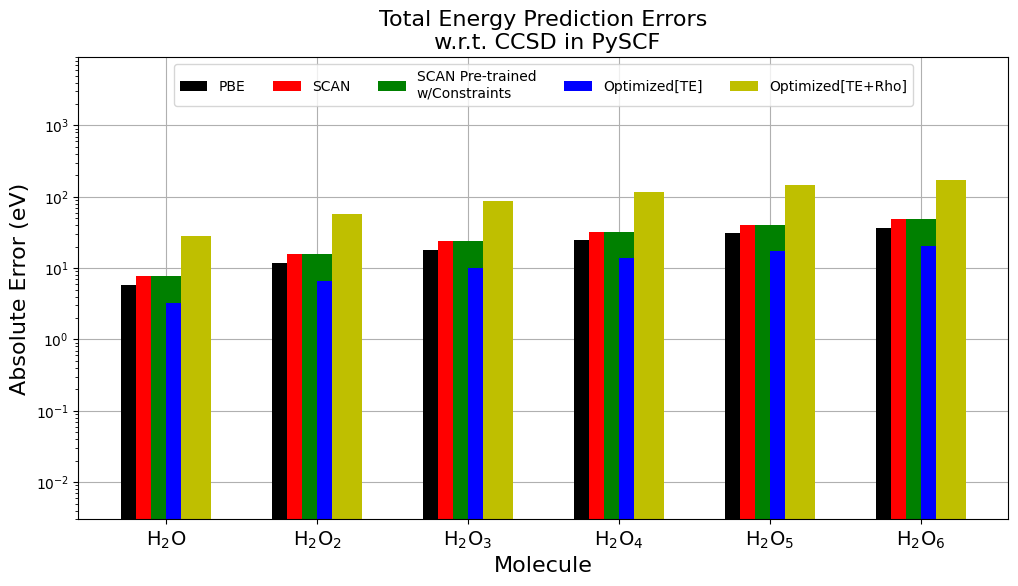

In [ ]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_system_ticklabels = ['H$_2$O', 'H$_2$O$_2$', 'H$_2$O$_3$', 'H$_2$O$_4$', 'H$_2$O$_5$', 'H$_2$O$_6$']

ax.set_xticks(np.arange(1, len(relevant_system_ticklabels)+2), labels=relevant_system_ticklabels+[''], fontsize=14)
Energy_conv =  27.211386246
# Energy_conv =  1
for idx, sys in enumerate(relevant_systems):
    if sys in ['H3Op', 'OHm']:
        #error occurred for OHm, nans -- need to figure out 
        continue
    pbe_err = abs(cc_ens[sys] - pbe_ens[sys][0])*Energy_conv
    scan_err = abs(cc_ens[sys] - scan_ens[sys][0])*Energy_conv
    pre_err = abs(cc_ens[sys]-pre_ens[sys][0])*Energy_conv
    opt1_err = abs(cc_ens[sys]-opt1_ens[sys][0])*Energy_conv
    opt2_err = abs(cc_ens[sys]-opt2_ens[sys][0])*Energy_conv
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2, label = 'PBE')
        ax.bar( (idx+1)-0.1, scan_err, facecolor='r', width=0.2, label = 'SCAN')
        ax.bar( (idx+1), pre_err, facecolor='g', width=0.2, label='SCAN Pre-trained\nw/Constraints')
        ax.bar( (idx+1)+0.1, opt1_err, facecolor='b', width=0.2, label='Optimized[TE]')
        ax.bar( (idx+1)+0.2, opt2_err, facecolor='y', width=0.2, label='Optimized[TE+Rho]')
    else: 
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2)
        ax.bar( (idx+1)-0.1, scan_err, facecolor='r', width=0.2)
        ax.bar( (idx+1), pre_err, facecolor='g', width=0.2)
        ax.bar( (idx+1)+0.1, opt1_err, facecolor='b', width=0.2)
        ax.bar( (idx+1)+0.2, opt2_err, facecolor='y', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend(ncol = 5, loc='upper center')
ax.set_yscale('log')
ax.set_ylim(3e-3, 9e3)
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (eV)', fontsize=16)
ax.set_title('Total Energy Prediction Errors\n w.r.t. CCSD in PySCF', fontsize=16)

In [ ]:
print([np.mean(abs(cc_rho[k] - cc_rho[k])) for k in cc_ens.keys()])
print()
print([np.mean(abs(pbe_rho[k] - cc_rho[k])) for k in cc_ens.keys()])
print()
print([np.mean(abs(pre_rho[k] - cc_rho[k])) for k in cc_ens.keys()])
print()
print([np.mean(abs(opt1_rho[k] - cc_rho[k])) for k in cc_ens.keys()])
print()
print([np.mean(abs(opt2_rho[k] - cc_rho[k])) for k in cc_ens.keys()])

[Array(0., dtype=float64), Array(0., dtype=float64), Array(0., dtype=float64), Array(0., dtype=float64), Array(0., dtype=float64), Array(0., dtype=float64), Array(0., dtype=float64), 0.0]

[Array(49.59596165, dtype=float64), Array(51.94300883, dtype=float64), Array(54.92091054, dtype=float64), Array(323.03741039, dtype=float64), Array(268.65521655, dtype=float64), Array(238.48941657, dtype=float64), Array(60.68307357, dtype=float64), 0.0]

[Array(49.49701881, dtype=float64), Array(51.87637512, dtype=float64), Array(54.88485773, dtype=float64), Array(323.02930115, dtype=float64), Array(268.66957466, dtype=float64), Array(238.48060125, dtype=float64), Array(1236.95205918, dtype=float64), 0.0]

[Array(49.86044539, dtype=float64), Array(52.30253163, dtype=float64), Array(55.35999964, dtype=float64), Array(323.55693864, dtype=float64), Array(269.21298097, dtype=float64), Array(239.00720726, dtype=float64), Array(1236.95205918, dtype=float64), 0.0]

[Array(50.184904, dtype=float64), Array(52